In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa as ts
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
import time 
import datetime
import statsmodels.api as sm
# warning supression
import warnings
warnings.filterwarnings("ignore")

In [297]:
data = pd.read_csv('data_q1_1.csv')
data = data.iloc[:,1:]
#替换value of outlier using the value of 1129
data.iloc[327,1] = data.iloc[326,1]
data['mean_ewm_10'] = data['Number of reported results'].ewm(alpha = 0.25).mean()
data['mean_10'] = data['Number of reported results'].rolling(10,min_periods=1).mean()
data.index = data['Date']
data = data.drop(columns=['Date'])
#data = data.iloc[data['Number of reported results'].argmax():,:]
#9:1 set
data_training = data.iloc[:300,:]
data_testing = data.iloc[300:,:]

In [286]:
tmp_max = data['Number of reported results'].max()

<AxesSubplot:xlabel='Date'>

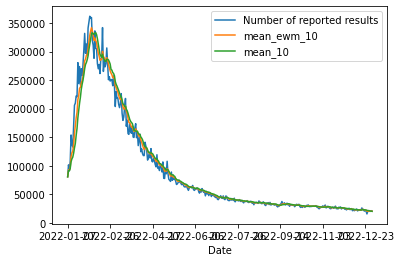

In [298]:
data.plot()

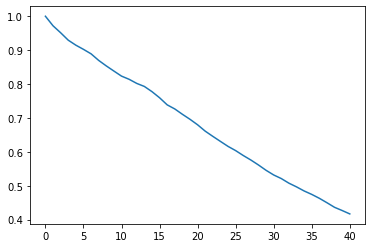

In [205]:
plt.plot(ts.stattools.acf(data['Number of reported results']))

# regression_ml model

In [251]:
data_training = data_training.reset_index()[['mean_ewm_10']]
data_training['time'] = data_training.index.values+1
rolling_price = data_training['mean_ewm_10'].values
mean = np.mean(rolling_price)
std = np.std(rolling_price)
normalize_price = (rolling_price-mean)/std
data_training['mean_ewm_10'] = normalize_price

In [264]:
x = 1/(data_training['time'].values)**2
X = sm.add_constant(x)
y = data_training['mean_ewm_10'].values
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     20.65
Date:                Sat, 18 Feb 2023   Prob (F-statistic):           8.01e-06
Time:                        09:55:06   Log-Likelihood:                -415.63
No. Observations:                 300   AIC:                             835.3
Df Residuals:                     298   BIC:                             842.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0233      0.056     -0.414      0.6

In [265]:
pred_ols = results.get_prediction()
pred_ols.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,4.232820,0.933114,2.396492,6.069148,1.583619,6.882020
1,1.040738,0.235766,0.576760,1.504715,-0.924316,3.005792
2,0.449612,0.113696,0.225863,0.673360,-1.472945,2.372168
3,0.242717,0.077401,0.090396,0.395038,-1.672841,2.158275
4,0.146955,0.064683,0.019661,0.274249,-1.766776,2.060685
...,...,...,...,...,...,...
295,-0.023241,0.056253,-0.133944,0.087462,-1.935940,1.889458
296,-0.023241,0.056253,-0.133944,0.087462,-1.935940,1.889457
297,-0.023242,0.056253,-0.133945,0.087461,-1.935940,1.889457
298,-0.023242,0.056253,-0.133945,0.087461,-1.935941,1.889457


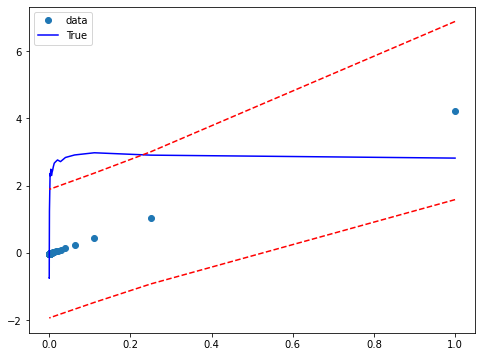

In [266]:
pred_ols = results.get_prediction()
y_pred = pred_ols.summary_frame()['mean'].values
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x, y_pred, "o", label="data")
ax.plot(x, y, "b-", label="True")
#ax.plot(x, res.fittedvalues, "r--.", label="OLS")
ax.plot(x, iv_u, "r--")
ax.plot(x, iv_l, "r--")
ax.legend(loc="best")

# time series model

In [207]:
def time_series_measurement(res,data,verify_type="test"):
    result = res.summary()
    if verify_type == "train":
        predict = res.predict()
        plt.plot(data)
        plt.title('train effort')
    elif verify_type == "test":
        predict_time = [pd.Timestamp(i) for i in data.index]
        predict = res.predict(predict_time[0],predict_time[-1])
        data['predict'] = predict.values
        
    return result,data


In [220]:
def regression(i_range = 50,j_range = 5,k_range = 3,data_training = data_training,data_testing = data_testing,re_type = 'ARMA'):

    for i in range (10,i_range,5):
        print("lag",i)
        if re_type == 'AR':
            res = AutoReg(data_training.iloc[:,2],lags=i,trend='ct').fit()
            summary,data = time_series_measurement(res,data=data_testing,verify_type = "test")
            print(summary)
            plt.plot(data)
            plt.show()
        else:
            for j in range(1,j_range):
                print("lag",j)
                if re_type == 'ARMA':
                    res = ARIMA(data_training.iloc[:,2],order = (i,0,j)).fit()
                elif re_type == 'ARIMA':
                    res = ARIMA(data_training.iloc[:,2],order = (i,1,j)).fit()
                summary,data = time_series_measurement(res,data=data_testing,verify_type = "test")
                print(summary)
                plt.plot(data)
                plt.show()


### Auro regression

lag 20
                            AutoReg Model Results                             
Dep. Variable:                mean_10   No. Observations:                  300
Model:                    AutoReg(20)   Log Likelihood               -2242.181
Method:               Conditional MLE   S.D. of innovations            726.946
Date:                Sat, 18 Feb 2023   AIC                             13.342
Time:                        08:49:53   BIC                             13.641
Sample:                    02-22-2022   HQIC                            13.462
                         - 11-28-2022                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept     433.9262    270.876      1.602      0.109     -96.981     964.833
trend          -0.6069      1.117     -0.543      0.587      -2.796       1.582
mean_10.L1      1.1518      0.060     19.

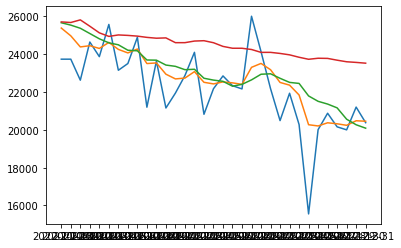

lag 25
                            AutoReg Model Results                             
Dep. Variable:                mean_10   No. Observations:                  300
Model:                    AutoReg(25)   Log Likelihood               -2164.901
Method:               Conditional MLE   S.D. of innovations            634.876
Date:                Sat, 18 Feb 2023   AIC                             13.110
Time:                        08:49:54   BIC                             13.479
Sample:                    02-27-2022   HQIC                            13.258
                         - 11-28-2022                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept     803.7385    258.988      3.103      0.002     296.132    1311.345
trend          -1.2348      1.022     -1.209      0.227      -3.237       0.768
mean_10.L1      1.0973      0.060     18.

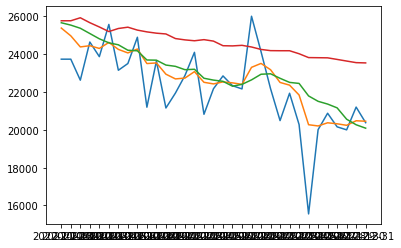

lag 30
                            AutoReg Model Results                             
Dep. Variable:                mean_10   No. Observations:                  300
Model:                    AutoReg(30)   Log Likelihood               -2108.658
Method:               Conditional MLE   S.D. of innovations            596.397
Date:                Sat, 18 Feb 2023   AIC                             13.026
Time:                        08:49:54   BIC                             13.466
Sample:                    03-04-2022   HQIC                            13.203
                         - 11-28-2022                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept     969.8697    280.379      3.459      0.001     420.336    1519.403
trend          -0.7758      1.013     -0.766      0.444      -2.762       1.210
mean_10.L1      1.0281      0.060     17.

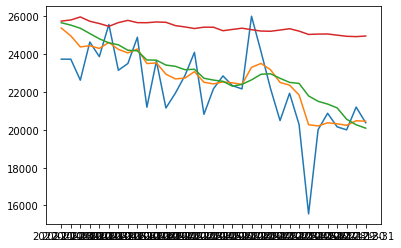

lag 35
                            AutoReg Model Results                             
Dep. Variable:                mean_10   No. Observations:                  300
Model:                    AutoReg(35)   Log Likelihood               -2055.496
Method:               Conditional MLE   S.D. of innovations            565.466
Date:                Sat, 18 Feb 2023   AIC                             12.962
Time:                        08:49:54   BIC                             13.475
Sample:                    03-09-2022   HQIC                            13.168
                         - 11-28-2022                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    1413.5473    307.399      4.598      0.000     811.056    2016.039
trend          -0.8673      1.003     -0.865      0.387      -2.833       1.098
mean_10.L1      0.9624      0.061     15.

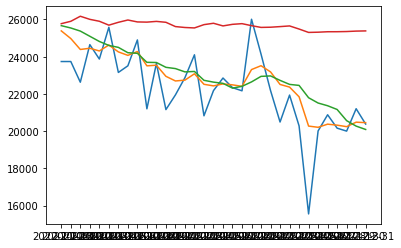

lag 40
                            AutoReg Model Results                             
Dep. Variable:                mean_10   No. Observations:                  300
Model:                    AutoReg(40)   Log Likelihood               -1963.232
Method:               Conditional MLE   S.D. of innovations            460.334
Date:                Sat, 18 Feb 2023   AIC                             12.595
Time:                        08:49:54   BIC                             13.184
Sample:                    03-14-2022   HQIC                            12.831
                         - 11-28-2022                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    1692.9659    332.185      5.096      0.000    1041.895    2344.037
trend          -2.2805      0.874     -2.609      0.009      -3.994      -0.567
mean_10.L1      0.9652      0.058     16.

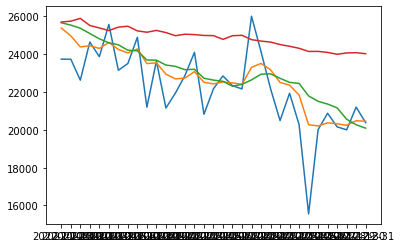

lag 45
                            AutoReg Model Results                             
Dep. Variable:                mean_10   No. Observations:                  300
Model:                    AutoReg(45)   Log Likelihood               -1877.538
Method:               Conditional MLE   S.D. of innovations            381.440
Date:                Sat, 18 Feb 2023   AIC                             12.264
Time:                        08:49:55   BIC                             12.931
Sample:                    03-19-2022   HQIC                            12.533
                         - 11-28-2022                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept    1064.4470    315.341      3.376      0.001     446.390    1682.504
trend          -0.8890      0.772     -1.152      0.249      -2.402       0.624
mean_10.L1      1.0564      0.061     17.

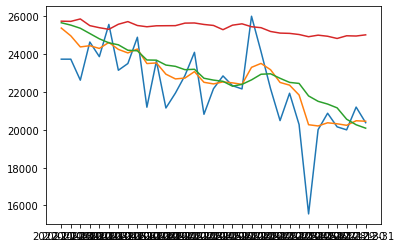

In [215]:
regression(re_type="AR")
    

### ARMA

lag 10
lag 1
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(10, 0, 1)   Log Likelihood               -2628.652
Date:                Sat, 18 Feb 2023   AIC                           5283.303
Time:                        09:11:13   BIC                           5331.452
Sample:                    02-02-2022   HQIC                          5302.573
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   2.89e-08   3.15e+12      0.000    9.11e+04    9.11e+04
ar.L1          0.6165      0.024     26.050      0.000       0.570       0.663
ar.L2          1.0913      0.037     29

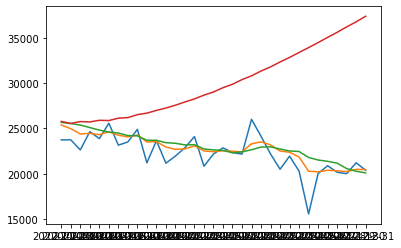

lag 2
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(10, 0, 2)   Log Likelihood               -2602.031
Date:                Sat, 18 Feb 2023   AIC                           5232.063
Time:                        09:11:14   BIC                           5283.916
Sample:                    02-02-2022   HQIC                          5252.814
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   9.75e-09   9.35e+12      0.000    9.11e+04    9.11e+04
ar.L1          0.1676      0.029      5.830      0.000       0.111       0.224
ar.L2          0.9894      0.036     27.252   

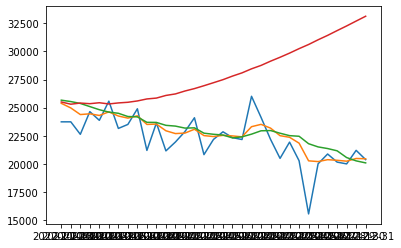

lag 3
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(10, 0, 3)   Log Likelihood               -2611.511
Date:                Sat, 18 Feb 2023   AIC                           5253.021
Time:                        09:11:16   BIC                           5308.578
Sample:                    02-02-2022   HQIC                          5275.255
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   4.52e-08   2.02e+12      0.000    9.11e+04    9.11e+04
ar.L1          0.3648      0.084      4.340      0.000       0.200       0.530
ar.L2          0.5199      0.095      5.500   

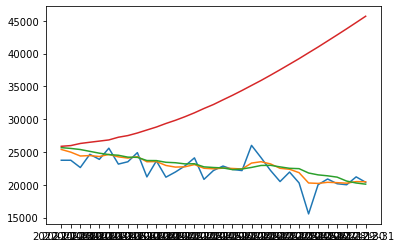

lag 4
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(10, 0, 4)   Log Likelihood               -2604.398
Date:                Sat, 18 Feb 2023   AIC                           5240.795
Time:                        09:11:17   BIC                           5300.056
Sample:                    02-02-2022   HQIC                          5264.511
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   2.27e-08   4.02e+12      0.000    9.11e+04    9.11e+04
ar.L1          0.1959      0.017     11.807      0.000       0.163       0.228
ar.L2          0.3838      0.016     23.338   

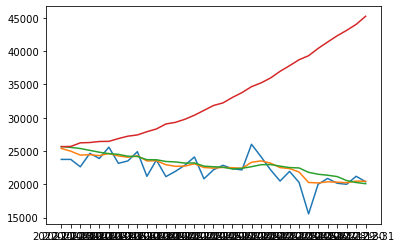

lag 15
lag 1
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(15, 0, 1)   Log Likelihood               -2564.290
Date:                Sat, 18 Feb 2023   AIC                           5164.580
Time:                        09:11:19   BIC                           5231.248
Sample:                    02-02-2022   HQIC                          5191.261
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04    3.1e-07   2.94e+11      0.000    9.11e+04    9.11e+04
ar.L1          0.7928      0.088      8.962      0.000       0.619       0.966
ar.L2          0.7423      0.125      5

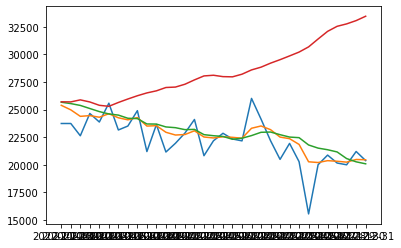

lag 2
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(15, 0, 2)   Log Likelihood               -2553.075
Date:                Sat, 18 Feb 2023   AIC                           5144.151
Time:                        09:11:21   BIC                           5214.523
Sample:                    02-02-2022   HQIC                          5172.314
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   8.04e-09   1.13e+13      0.000    9.11e+04    9.11e+04
ar.L1          0.2914      0.021     13.763      0.000       0.250       0.333
ar.L2          0.7849      0.026     29.932   

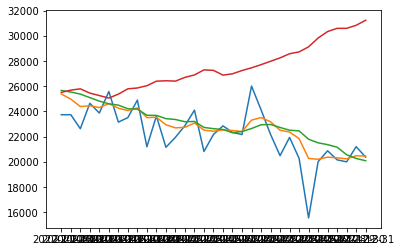

lag 3
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(15, 0, 3)   Log Likelihood               -2552.211
Date:                Sat, 18 Feb 2023   AIC                           5144.423
Time:                        09:11:23   BIC                           5218.498
Sample:                    02-02-2022   HQIC                          5174.068
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   3.13e-08   2.91e+12      0.000    9.11e+04    9.11e+04
ar.L1          0.5349      0.031     17.025      0.000       0.473       0.596
ar.L2          0.5992      0.039     15.367   

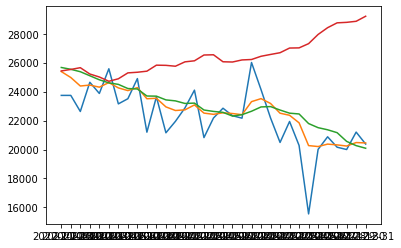

lag 4
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(15, 0, 4)   Log Likelihood               -2541.609
Date:                Sat, 18 Feb 2023   AIC                           5125.217
Time:                        09:11:26   BIC                           5202.997
Sample:                    02-02-2022   HQIC                          5156.345
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   4.08e-08   2.23e+12      0.000    9.11e+04    9.11e+04
ar.L1          0.3043      0.064      4.755      0.000       0.179       0.430
ar.L2          0.8444      0.070     12.054   

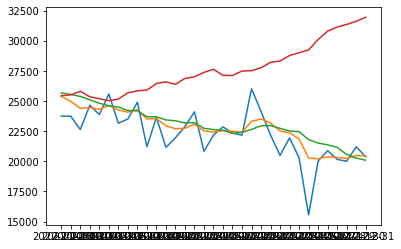

lag 20
lag 1
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(20, 0, 1)   Log Likelihood               -2567.817
Date:                Sat, 18 Feb 2023   AIC                           5181.633
Time:                        09:11:29   BIC                           5266.820
Sample:                    02-02-2022   HQIC                          5215.725
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04    8.6e-08   1.06e+12      0.000    9.11e+04    9.11e+04
ar.L1          0.4541      0.031     14.847      0.000       0.394       0.514
ar.L2          1.2067      0.038     31

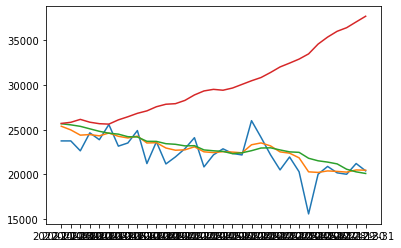

lag 2
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(20, 0, 2)   Log Likelihood               -2576.213
Date:                Sat, 18 Feb 2023   AIC                           5200.425
Time:                        09:11:32   BIC                           5289.316
Sample:                    02-02-2022   HQIC                          5235.999
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   7.43e-08   1.23e+12      0.000    9.11e+04    9.11e+04
ar.L1         -0.0486      0.037     -1.304      0.192      -0.122       0.024
ar.L2          1.0878      0.039     27.561   

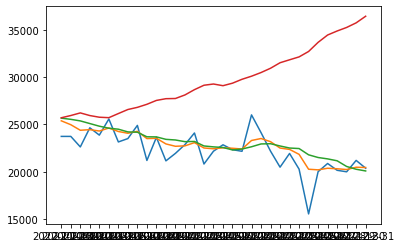

lag 3
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(20, 0, 3)   Log Likelihood               -2559.743
Date:                Sat, 18 Feb 2023   AIC                           5169.485
Time:                        09:11:36   BIC                           5262.080
Sample:                    02-02-2022   HQIC                          5206.542
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   3.18e-07   2.86e+11      0.000    9.11e+04    9.11e+04
ar.L1         -0.0320      0.090     -0.357      0.721      -0.208       0.144
ar.L2          0.6247      0.040     15.708   

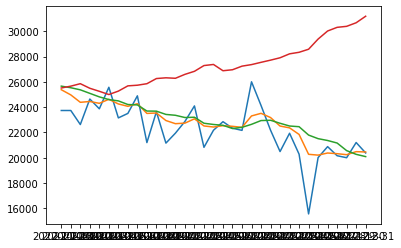

lag 4
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(20, 0, 4)   Log Likelihood               -2522.649
Date:                Sat, 18 Feb 2023   AIC                           5097.298
Time:                        09:11:39   BIC                           5193.597
Sample:                    02-02-2022   HQIC                          5135.837
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   2.79e-08   3.27e+12      0.000    9.11e+04    9.11e+04
ar.L1          0.4345      0.036     11.904      0.000       0.363       0.506
ar.L2          0.4039      0.046      8.827   

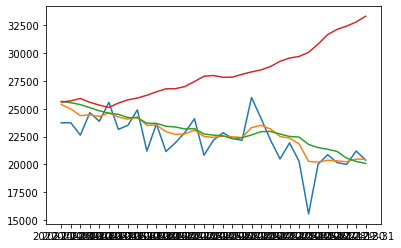

lag 25
lag 1
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(25, 0, 1)   Log Likelihood               -2561.709
Date:                Sat, 18 Feb 2023   AIC                           5179.419
Time:                        09:11:44   BIC                           5283.125
Sample:                    02-02-2022   HQIC                          5220.922
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   2.03e-06   4.49e+10      0.000    9.11e+04    9.11e+04
ar.L1          0.7790      0.340      2.293      0.022       0.113       1.445
ar.L2          0.8086      0.448      1

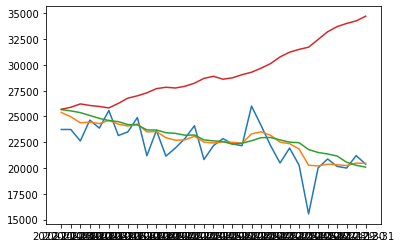

lag 2
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(25, 0, 2)   Log Likelihood               -2557.236
Date:                Sat, 18 Feb 2023   AIC                           5172.472
Time:                        09:11:49   BIC                           5279.882
Sample:                    02-02-2022   HQIC                          5215.458
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   1.54e-07    5.9e+11      0.000    9.11e+04    9.11e+04
ar.L1         -0.1950      0.055     -3.572      0.000      -0.302      -0.088
ar.L2          1.2432      0.038     32.302   

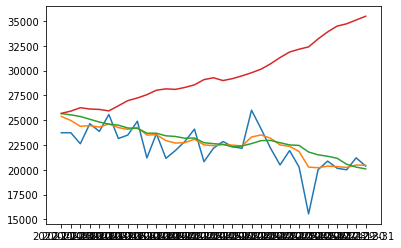

lag 3
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(25, 0, 3)   Log Likelihood               -2541.056
Date:                Sat, 18 Feb 2023   AIC                           5142.112
Time:                        09:11:53   BIC                           5253.225
Sample:                    02-02-2022   HQIC                          5186.580
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   6.96e-08   1.31e+12      0.000    9.11e+04    9.11e+04
ar.L1         -0.6889      0.033    -20.828      0.000      -0.754      -0.624
ar.L2          0.8556      0.035     24.485   

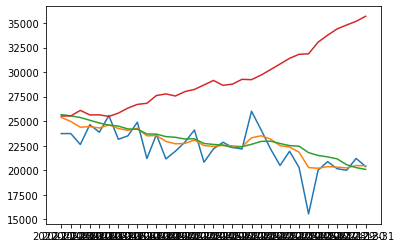

lag 4
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(25, 0, 4)   Log Likelihood               -2549.983
Date:                Sat, 18 Feb 2023   AIC                           5161.966
Time:                        09:12:00   BIC                           5276.783
Sample:                    02-02-2022   HQIC                          5207.916
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   6.16e-06   1.48e+10      0.000    9.11e+04    9.11e+04
ar.L1          0.2467      0.781      0.316      0.752      -1.283       1.777
ar.L2          0.8037      0.311      2.586   

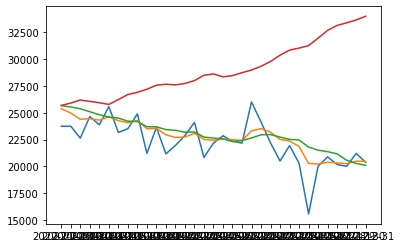

lag 30
lag 1
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(30, 0, 1)   Log Likelihood               -2552.558
Date:                Sat, 18 Feb 2023   AIC                           5171.115
Time:                        09:12:08   BIC                           5293.340
Sample:                    02-02-2022   HQIC                          5220.030
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   9.64e-08   9.45e+11      0.000    9.11e+04    9.11e+04
ar.L1          0.7436      0.265      2.802      0.005       0.224       1.264
ar.L2          0.8048      0.356      2

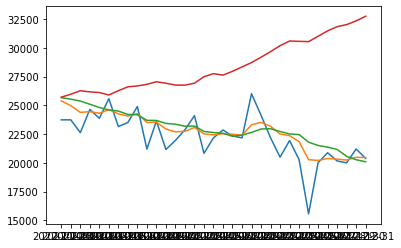

lag 2
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(30, 0, 2)   Log Likelihood               -2572.913
Date:                Sat, 18 Feb 2023   AIC                           5213.827
Time:                        09:12:15   BIC                           5339.755
Sample:                    02-02-2022   HQIC                          5264.223
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   8.24e-08   1.11e+12      0.000    9.11e+04    9.11e+04
ar.L1         -0.1681      0.068     -2.457      0.014      -0.302      -0.034
ar.L2          1.2623      0.051     24.704   

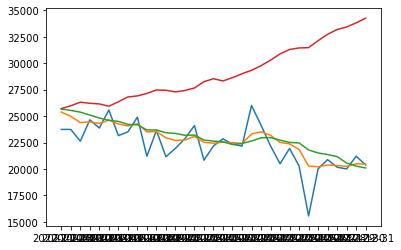

lag 3
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(30, 0, 3)   Log Likelihood               -2536.764
Date:                Sat, 18 Feb 2023   AIC                           5143.529
Time:                        09:12:23   BIC                           5273.161
Sample:                    02-02-2022   HQIC                          5195.408
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   8.17e-08   1.11e+12      0.000    9.11e+04    9.11e+04
ar.L1         -0.3995      0.040    -10.049      0.000      -0.477      -0.322
ar.L2          0.7290      0.036     20.327   

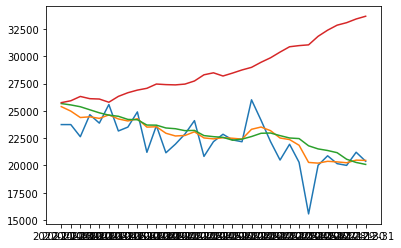

lag 4
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(30, 0, 4)   Log Likelihood               -2540.563
Date:                Sat, 18 Feb 2023   AIC                           5153.125
Time:                        09:12:31   BIC                           5286.461
Sample:                    02-02-2022   HQIC                          5206.486
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   1.08e-07   8.45e+11      0.000    9.11e+04    9.11e+04
ar.L1          0.4283      0.066      6.509      0.000       0.299       0.557
ar.L2          1.0414      0.083     12.574   

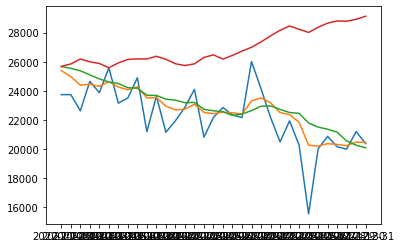

lag 35
lag 1
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(35, 0, 1)   Log Likelihood               -2538.787
Date:                Sat, 18 Feb 2023   AIC                           5153.575
Time:                        09:12:48   BIC                           5294.318
Sample:                    02-02-2022   HQIC                          5209.901
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   2.65e-08   3.43e+12      0.000    9.11e+04    9.11e+04
ar.L1          0.4714      0.034     13.992      0.000       0.405       0.537
ar.L2          1.1263      0.035     32

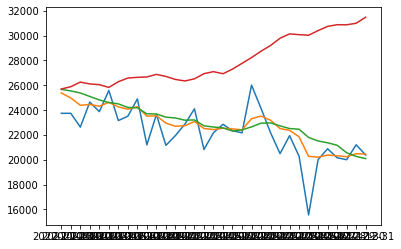

lag 2
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(35, 0, 2)   Log Likelihood               -2557.991
Date:                Sat, 18 Feb 2023   AIC                           5193.982
Time:                        09:13:05   BIC                           5338.429
Sample:                    02-02-2022   HQIC                          5251.790
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   9.69e-08   9.41e+11      0.000    9.11e+04    9.11e+04
ar.L1         -0.2550      0.074     -3.435      0.001      -0.401      -0.109
ar.L2          1.3479      0.041     32.542   

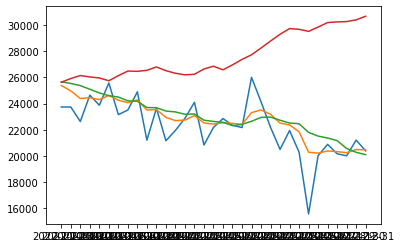

lag 3
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(35, 0, 3)   Log Likelihood               -2539.734
Date:                Sat, 18 Feb 2023   AIC                           5159.469
Time:                        09:13:20   BIC                           5307.620
Sample:                    02-02-2022   HQIC                          5218.759
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04    4.9e-07   1.86e+11      0.000    9.11e+04    9.11e+04
ar.L1          0.3723      0.128      2.910      0.004       0.122       0.623
ar.L2          0.5069      0.140      3.608   

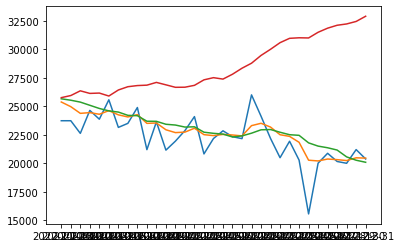

lag 4
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(35, 0, 4)   Log Likelihood               -2525.393
Date:                Sat, 18 Feb 2023   AIC                           5132.787
Time:                        09:13:36   BIC                           5284.642
Sample:                    02-02-2022   HQIC                          5193.559
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   8.63e-06   1.06e+10      0.000    9.11e+04    9.11e+04
ar.L1          0.4782      0.311      1.538      0.124      -0.131       1.088
ar.L2          0.7581      0.095      7.977   

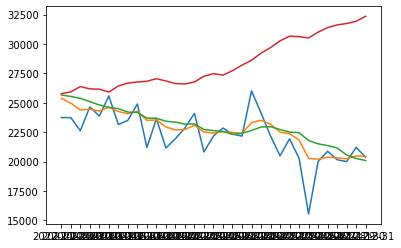

lag 40
lag 1
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(40, 0, 1)   Log Likelihood               -2620.392
Date:                Sat, 18 Feb 2023   AIC                           5326.784
Time:                        09:13:56   BIC                           5486.047
Sample:                    02-02-2022   HQIC                          5390.521
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04    2.1e-08   4.33e+12      0.000    9.11e+04    9.11e+04
ar.L1          0.7478      0.038     19.685      0.000       0.673       0.822
ar.L2          0.7741      0.041     19

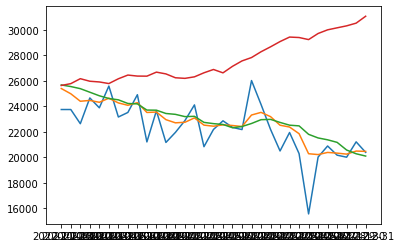

lag 2
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(40, 0, 2)   Log Likelihood               -2625.313
Date:                Sat, 18 Feb 2023   AIC                           5338.626
Time:                        09:14:13   BIC                           5501.592
Sample:                    02-02-2022   HQIC                          5403.845
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   2.49e-06   3.66e+10      0.000    9.11e+04    9.11e+04
ar.L1          0.5894      0.246      2.392      0.017       0.106       1.072
ar.L2          0.8204      0.172      4.776   

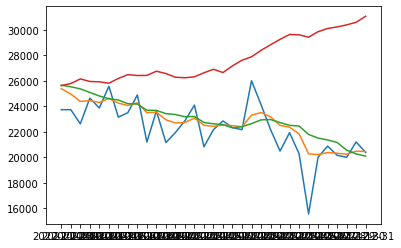

lag 3
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(40, 0, 3)   Log Likelihood               -2639.382
Date:                Sat, 18 Feb 2023   AIC                           5368.764
Time:                        09:14:32   BIC                           5535.434
Sample:                    02-02-2022   HQIC                          5435.465
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04      0.001   1.73e+08      0.000    9.11e+04    9.11e+04
ar.L1          0.3934      5.226      0.075      0.940      -9.849      10.636
ar.L2          0.8511      2.132      0.399   

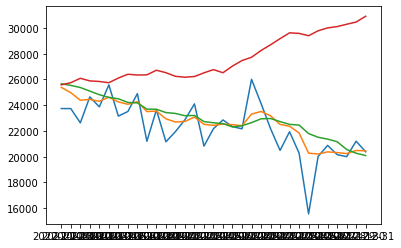

lag 4
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(40, 0, 4)   Log Likelihood               -2635.903
Date:                Sat, 18 Feb 2023   AIC                           5363.807
Time:                        09:14:53   BIC                           5534.181
Sample:                    02-02-2022   HQIC                          5431.991
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   6.27e-08   1.45e+12      0.000    9.11e+04    9.11e+04
ar.L1          0.7559      0.082      9.213      0.000       0.595       0.917
ar.L2          0.3868      0.076      5.092   

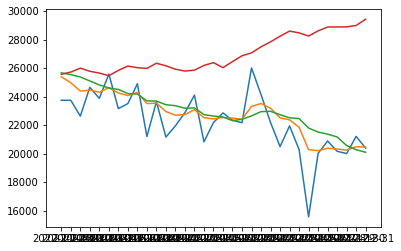

lag 45
lag 1
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(45, 0, 1)   Log Likelihood               -2764.357
Date:                Sat, 18 Feb 2023   AIC                           5624.714
Time:                        09:15:20   BIC                           5802.495
Sample:                    02-02-2022   HQIC                          5695.862
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04    4.2e-08   2.17e+12      0.000    9.11e+04    9.11e+04
ar.L1          0.5150      0.044     11.712      0.000       0.429       0.601
ar.L2          1.0491      0.059     17

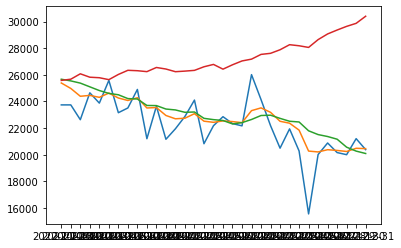

lag 2
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(45, 0, 2)   Log Likelihood               -2769.023
Date:                Sat, 18 Feb 2023   AIC                           5636.046
Time:                        09:15:45   BIC                           5817.532
Sample:                    02-02-2022   HQIC                          5708.677
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   1.38e-07   6.62e+11      0.000    9.11e+04    9.11e+04
ar.L1         -0.0193      0.053     -0.367      0.713      -0.122       0.084
ar.L2          1.0157      0.048     21.025   

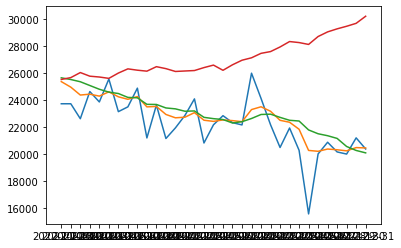

lag 3
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(45, 0, 3)   Log Likelihood               -2722.834
Date:                Sat, 18 Feb 2023   AIC                           5545.668
Time:                        09:16:10   BIC                           5730.857
Sample:                    02-02-2022   HQIC                          5619.781
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   2.77e-08   3.29e+12      0.000    9.11e+04    9.11e+04
ar.L1         -0.1351      0.031     -4.382      0.000      -0.196      -0.075
ar.L2          0.5322      0.025     21.245   

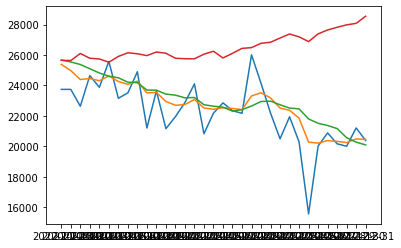

lag 4
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(45, 0, 4)   Log Likelihood               -2727.336
Date:                Sat, 18 Feb 2023   AIC                           5556.672
Time:                        09:16:35   BIC                           5745.565
Sample:                    02-02-2022   HQIC                          5632.267
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   7.28e-07   1.25e+11      0.000    9.11e+04    9.11e+04
ar.L1         -0.7314      0.098     -7.432      0.000      -0.924      -0.538
ar.L2          0.2308      0.039      5.851   

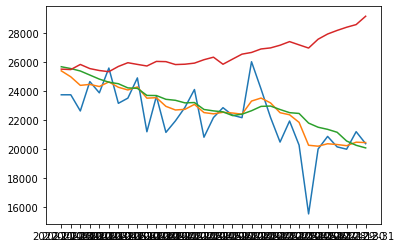

In [221]:
regression() #type2 lag j20 i10/j20 i5

                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(5, 0, 20)   Log Likelihood               -2809.095
Date:                Sat, 18 Feb 2023   AIC                           5672.190
Time:                        08:30:53   BIC                           5772.192
Sample:                    02-02-2022   HQIC                          5712.211
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.113e+04   2.47e-05   3.68e+09      0.000    9.11e+04    9.11e+04
ar.L1          0.4301      0.029     14.664      0.000       0.373       0.488
ar.L2          0.9062      0.037     24.333      0.0

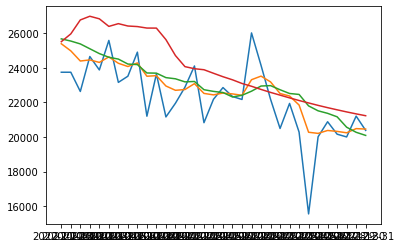

In [191]:
res = ARIMA(data_training.iloc[:,2],order = (5,0,20)).fit()
summary,data = time_series_measurement(res,data=data_testing,verify_type = "test")
print(summary)
plt.plot(data)

### ARIMA

lag 20
lag 5
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(20, 1, 5)   Log Likelihood               -2957.207
Date:                Sat, 18 Feb 2023   AIC                           5966.414
Time:                        09:04:21   BIC                           6062.626
Sample:                    02-02-2022   HQIC                          6004.923
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0026      0.076     -0.035      0.972      -0.152       0.147
ar.L2          0.1556      0.057      2.747      0.006       0.045       0.267
ar.L3         -0.0277      0.057     -0

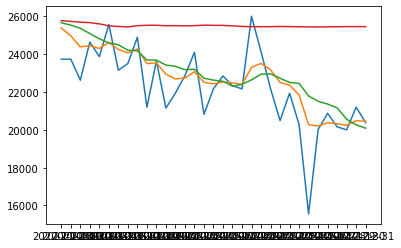

lag 10
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:               ARIMA(20, 1, 10)   Log Likelihood               -3121.167
Date:                Sat, 18 Feb 2023   AIC                           6304.335
Time:                        09:04:25   BIC                           6419.049
Sample:                    02-02-2022   HQIC                          6350.249
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3064      0.030     10.074      0.000       0.247       0.366
ar.L2         -0.2208      0.021    -10.427      0.000      -0.262      -0.179
ar.L3          0.0921      0.016      5.663  

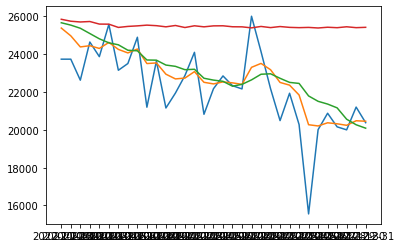

lag 25
lag 5
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(25, 1, 5)   Log Likelihood               -2985.638
Date:                Sat, 18 Feb 2023   AIC                           6033.275
Time:                        09:04:31   BIC                           6147.989
Sample:                    02-02-2022   HQIC                          6079.189
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2617      0.015    -17.573      0.000      -0.291      -0.232
ar.L2         -0.0421      0.013     -3.176      0.001      -0.068      -0.016
ar.L3          0.2392      0.013     19

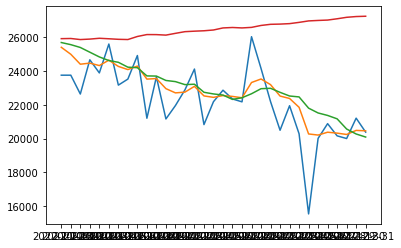

lag 10
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:               ARIMA(25, 1, 10)   Log Likelihood               -3024.203
Date:                Sat, 18 Feb 2023   AIC                           6120.407
Time:                        09:04:37   BIC                           6253.622
Sample:                    02-02-2022   HQIC                          6173.726
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0205      0.016     -1.245      0.213      -0.053       0.012
ar.L2          0.0153      0.012      1.305      0.192      -0.008       0.038
ar.L3         -0.1108      0.010    -10.707  

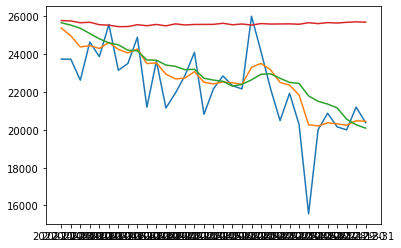

lag 30
lag 5
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(30, 1, 5)   Log Likelihood               -3007.651
Date:                Sat, 18 Feb 2023   AIC                           6087.302
Time:                        09:04:46   BIC                           6220.518
Sample:                    02-02-2022   HQIC                          6140.621
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4173      0.016    -26.025      0.000      -0.449      -0.386
ar.L2          0.1847      0.011     17.203      0.000       0.164       0.206
ar.L3          0.0240      0.009      2

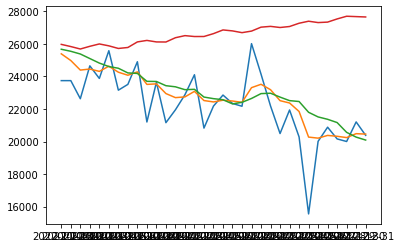

lag 10
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:               ARIMA(30, 1, 10)   Log Likelihood               -3012.480
Date:                Sat, 18 Feb 2023   AIC                           6106.961
Time:                        09:04:55   BIC                           6258.679
Sample:                    02-02-2022   HQIC                          6167.685
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2276      0.083     -2.743      0.006      -0.390      -0.065
ar.L2         -0.0872      0.062     -1.401      0.161      -0.209       0.035
ar.L3         -0.0802      0.049     -1.640  

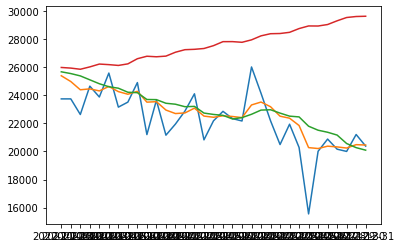

lag 35
lag 5
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(35, 1, 5)   Log Likelihood               -3127.742
Date:                Sat, 18 Feb 2023   AIC                           6337.485
Time:                        09:05:10   BIC                           6489.203
Sample:                    02-02-2022   HQIC                          6398.209
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2583      0.086     -3.008      0.003      -0.427      -0.090
ar.L2          0.1654      0.055      3.008      0.003       0.058       0.273
ar.L3          0.0084      0.035      0

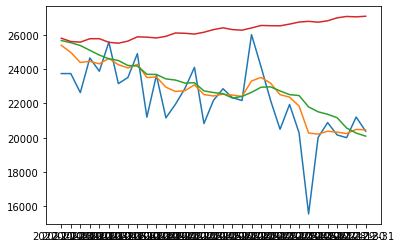

lag 10
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:               ARIMA(35, 1, 10)   Log Likelihood               -3163.308
Date:                Sat, 18 Feb 2023   AIC                           6418.616
Time:                        09:05:27   BIC                           6588.836
Sample:                    02-02-2022   HQIC                          6486.746
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1750      0.117      1.496      0.135      -0.054       0.404
ar.L2          0.5486      0.117      4.672      0.000       0.318       0.779
ar.L3          0.0960      0.066      1.454  

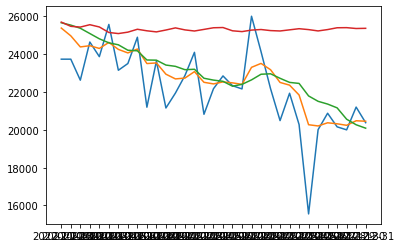

lag 40
lag 5
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(40, 1, 5)   Log Likelihood               -3609.633
Date:                Sat, 18 Feb 2023   AIC                           7311.266
Time:                        09:05:47   BIC                           7481.487
Sample:                    02-02-2022   HQIC                          7379.396
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2149      0.032      6.642      0.000       0.151       0.278
ar.L2          0.5268      0.022     23.647      0.000       0.483       0.570
ar.L3         -0.5802      0.005   -116

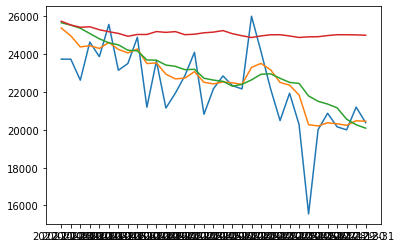

lag 10
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:               ARIMA(40, 1, 10)   Log Likelihood               -3661.192
Date:                Sat, 18 Feb 2023   AIC                           7424.384
Time:                        09:06:11   BIC                           7613.106
Sample:                    02-02-2022   HQIC                          7499.919
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0434      0.851     -0.051      0.959      -1.711       1.624
ar.L2          0.7449      0.492      1.515      0.130      -0.219       1.709
ar.L3         -0.4947      0.383     -1.292  

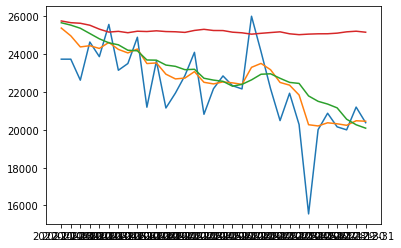

lag 45
lag 5
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:                ARIMA(45, 1, 5)   Log Likelihood               -3758.116
Date:                Sat, 18 Feb 2023   AIC                           7618.233
Time:                        09:06:36   BIC                           7806.955
Sample:                    02-02-2022   HQIC                          7693.768
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0512      0.008      6.080      0.000       0.035       0.068
ar.L2          0.6566      0.009     76.180      0.000       0.640       0.673
ar.L3          0.4915      0.009     57

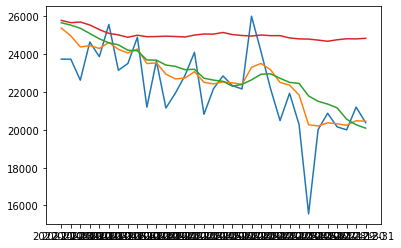

lag 10
                               SARIMAX Results                                
Dep. Variable:                mean_10   No. Observations:                  300
Model:               ARIMA(45, 1, 10)   Log Likelihood               -3735.009
Date:                Sat, 18 Feb 2023   AIC                           7582.018
Time:                        09:07:10   BIC                           7789.243
Sample:                    02-02-2022   HQIC                          7664.959
                         - 11-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5734      0.020     28.077      0.000       0.533       0.613
ar.L2         -0.0806      0.018     -4.564      0.000      -0.115      -0.046
ar.L3         -0.0644      0.018     -3.594  

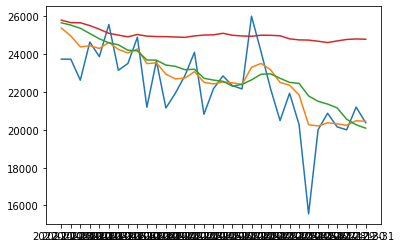

In [219]:
regression(re_type='ARIMA')

# special model

In [314]:
data = pd.read_csv('data_q1_1.csv')
data = data.iloc[:,1:]
#替换value of outlier using the value of 1129
data.iloc[327,1] = data.iloc[326,1]
data['mean_ewm_10'] = data['Number of reported results'].ewm(alpha = 0.25).mean()
data['mean_10'] = data['Number of reported results'].rolling(10,min_periods=1).mean()
data.index = data['Date']
data = data.drop(columns=['Date'])
#data = data.iloc[data['Number of reported results'].argmax():,:]
#9:1 set
data_training = data.iloc[:300,:]
data_testing = data.iloc[300:,:]

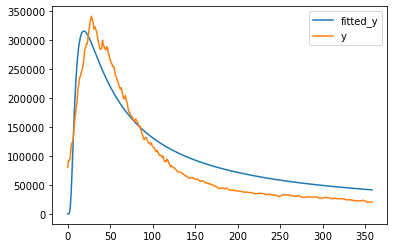

In [341]:
data = data.reset_index()[['mean_ewm_10']]
data['time'] = data.index.values+1
y = data['mean_ewm_10'].values
x = data['time'].values
_lambda = 32
offset = -0
fitted_y = 1/((np.exp(_lambda/(x-offset))-1)*(x-offset)**2)*500000000
plt.plot(fitted_y)
plt.plot(y)
plt.legend(['fitted_y','y'])

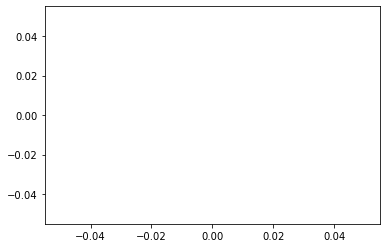

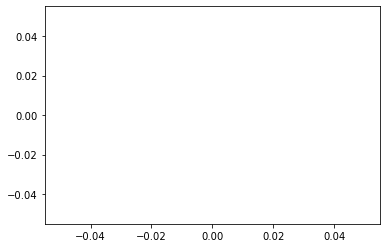

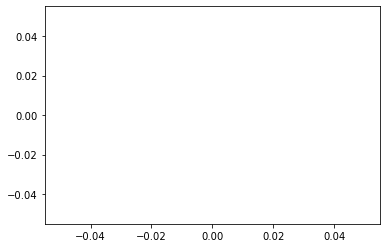

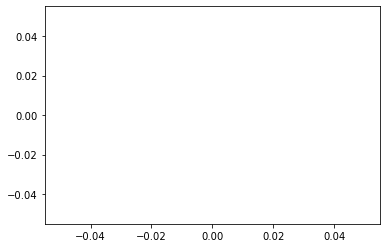

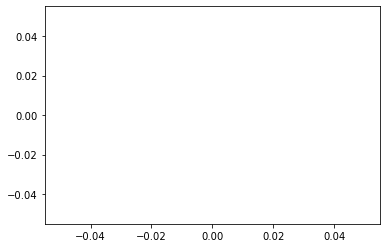

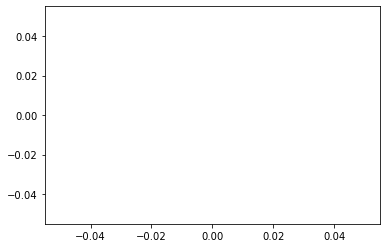

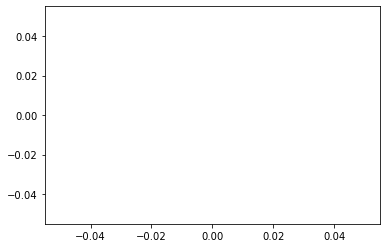

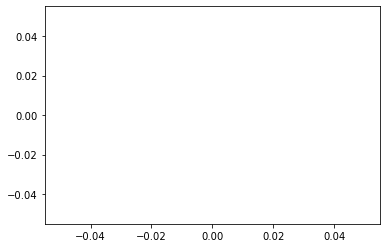

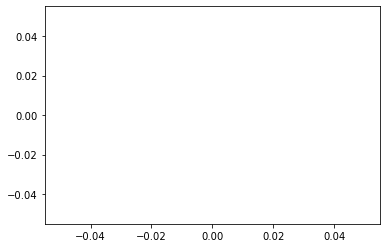

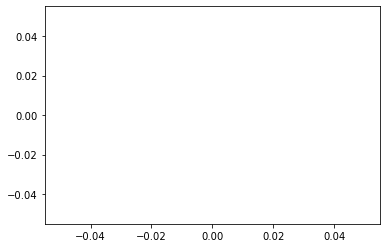

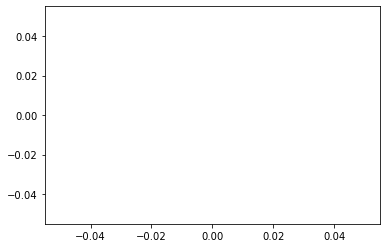

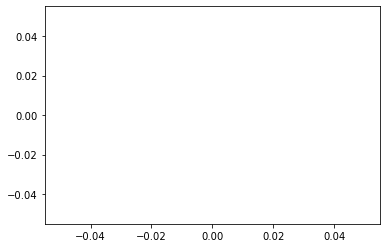

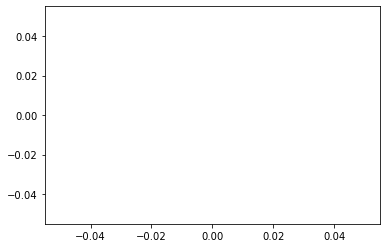

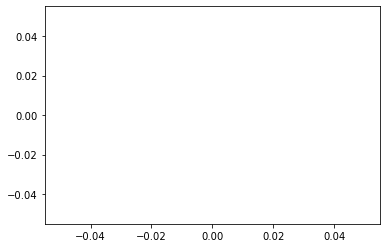

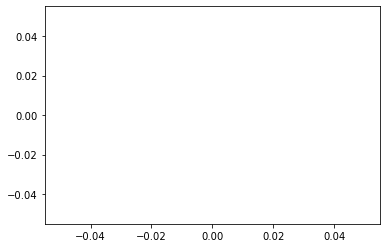

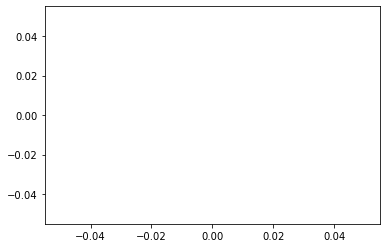

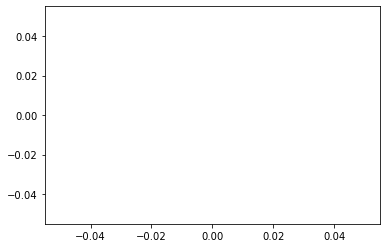

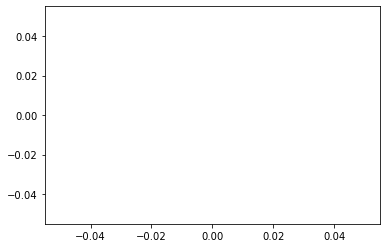

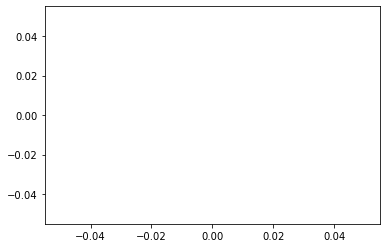

In [304]:

x = 1/((np.exp(j/x))*x**2)
plt.plot(y,x)
plt.show()
    